In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import os
import sys
from scipy import stats
import re
import random
from argparse import Namespace

sys.path.append('../src-py/')

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
%autoreload

from utils import *
from project_debater_api import *

In [4]:
from mt_bart_v2 import *
from ca_utils import *

2022-08-08 07:42:37,375 loading file ../../data-ceph/arguana/arg-generation/claim-target-tagger/model/final-model.pt
2022-08-08 07:43:10,092 SequenceTagger predicts: Dictionary with 4 tags: <unk>, B-CT, I-CT, O


In [5]:
import pickle
import torch
import json

import nltk
import numpy as np
import pandas as pd

from pathlib import Path
from tabulate import tabulate
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt

In [6]:
from datasets import load_dataset, load_metric, Dataset

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## General:

In [8]:
ceph_dir = '/home/sile2804/data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation'
local_home_dir = '../data'

data_unique_path = '/reddit_data/conclusion_and_ca_generation/test_conclusion_all_preprocessed.pkl'
#data_unique_path = '/reddit_data/conclusion_and_ca_generation/sample_test_conclusion_all_preprocessed.pkl'
data_path = '/reddit_data/conclusion_and_ca_generation/test_conclusion_all.pkl'

In [9]:
def generate_ds_attacks(ds, model, tokenizer, premises_clm, conclusion_clm, gen_kwargs, skip_special_tokens=True, batch_size=5):
    
    ds = ds.map(lambda x :preprocess_function(x, tokenizer, premises_clm, 'counter', conclusion_clm=conclusion_clm), batched=True)
    ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    dataloader = torch.utils.data.DataLoader(ds, batch_size=batch_size)
    attacks = generate_counters(model, tokenizer, dataloader, gen_kwargs, skip_special_tokens=skip_special_tokens)
    
    return attacks

def create_predictions_df(reddit_sample_valid_ds, gen_kwargs, premises_clm='masked_premises'):
    
    #joint_attacks       = generate_ds_attacks(reddit_sample_valid_ds, join_model, join_model_tokenizer, premises_clm, None, gen_kwargs)
    #noconc_attacks      = generate_ds_attacks(reddit_sample_valid_ds, no_conclusion_model, no_conclusion_tokenizer, premises_clm, None, gen_kwargs)
    
    known_conc_attacks  = generate_ds_attacks(reddit_sample_valid_ds, known_conclusion_model, known_conclusion_tokenizer, premises_clm, 'title', gen_kwargs)
    bart_conc_attacks   = generate_ds_attacks(reddit_sample_valid_ds, known_conclusion_model, known_conclusion_tokenizer, premises_clm, 'bart_conclusion', gen_kwargs)
    masked_conc_attacks = generate_ds_attacks(reddit_sample_valid_ds, known_conclusion_model, known_conclusion_tokenizer, premises_clm, None, gen_kwargs)
    
    #update max_gen_length to account to the generated conclusion
    gen_kwargs['max_length'] = gen_kwargs['max_length'] + 50
    joint_conc_baseline_attacks  = generate_ds_attacks(reddit_sample_valid_ds, pred_conclusion_model, pred_conclusion_tokenizer, premises_clm, None, gen_kwargs, skip_special_tokens=False)
    
    #gen_kwargs['max_length'] = gen_kwargs['max_length'] + 50
    #planning_attacks         = generate_ds_attacks(reddit_sample_valid_ds, planning_model, planning_model_tokenizer, premises_clm, None, gen_kwargs, skip_special_tokens=False)

    reddit_pred_df = pd.DataFrame(list(zip(
                                           reddit_sample_valid_ds['post_id'],
                                           reddit_sample_valid_ds['title'], 
                                           reddit_sample_valid_ds['conclusion_targets'],
                                           reddit_sample_valid_ds['conclusion_stance'],
                                           reddit_sample_valid_ds['bart_conclusion'], 
                                           reddit_sample_valid_ds[premises_clm],
                                           reddit_sample_valid_ds['counter'], 
                                           known_conc_attacks, masked_conc_attacks, 
                                           bart_conc_attacks, joint_conc_baseline_attacks)), 
                    columns=['post_id', 'conclusion', 'conclusion_target', 'conclusion_stance', 'bart_conclusion', 
                             'premises', 'gt_attack', 'known_conc_attacks', 'masked_conc_attacks', 
                             'bart_conc_attacks',  'joint_conc_baseline_attacks'])

    reddit_pred_df['argument'] = reddit_pred_df.apply(lambda row: row['conclusion'] + ' : ' + ' '.join(row['premises']), axis=1)
    reddit_pred_df['premises'] = reddit_pred_df['premises'].apply(lambda x: ' '.join(x))

    #process the jointly generated conclusion and counter
    reddit_pred_df['joint_conc_baseline'] = reddit_pred_df['joint_conc_baseline_attacks'].apply (lambda x: x.split('<counter>')[0])
    reddit_pred_df['joint_conc_baseline_attacks'] = reddit_pred_df['joint_conc_baseline_attacks'].apply (lambda x: x.split('<counter>')[1] if '<counter>' in x else x)
    reddit_pred_df['joint_conc_baseline'] = reddit_pred_df['joint_conc_baseline'].apply (lambda x: re.sub('<s>|</s>|<conclusion>|<counter>|<pad>', '', x).strip())
    reddit_pred_df['joint_conc_baseline_attacks'] = reddit_pred_df['joint_conc_baseline_attacks'].apply (lambda x: re.sub('<s>|</s>|<conclusion>|<counter>|<pad>', '', x).strip())

    #similar to the jointly generated conclusion and counter
    #reddit_pred_df['planning_counter_conclusion']  = reddit_pred_df['planning_attacks'].apply (lambda x: x.split('<claim>')[0])
    #reddit_pred_df['planning_counter_attack'] = reddit_pred_df['planning_attacks'].apply (lambda x: x.split('<claim>')[1] if '<claim>' in x else x)
    #reddit_pred_df['planning_counter_conclusion']  = reddit_pred_df['planning_counter_conclusion'].apply (lambda x: re.sub('<s>|</s>|<conclusion>|<counter>|<pad>', '', x).strip())
    #reddit_pred_df['planning_counter_attack'] = reddit_pred_df['planning_counter_attack'].apply (lambda x: re.sub('<s>|</s>|<conclusion>|<counter>|<pad>', '', x).strip())

    
    return reddit_pred_df

    
def get_evaluation_results(reddit_pred_df, df_path, pred_clms, batched=False, detailed=False):
    
    #collect references
    df = pd.read_pickle(df_path)
    #Remove the first character from counter if it is a special character...
    df['counter'] = df['counter'].apply(lambda counter_sents: [counter_sent for counter_sent in counter_sents if not counter_sent.startswith('!') and not counter_sent.startswith('.') and not counter_sent.startswith('?')])
    arg_counters = df.groupby('post_id').agg({
        'counter': lambda x: [' '.join(c) for c in x]
    }).reset_index()

    arg_counters = pd.Series(arg_counters.counter.values, index=arg_counters.post_id).to_dict()

    reddit_pred_df['all_counters'] = reddit_pred_df['post_id'].apply(lambda x: arg_counters[x])
    reddit_pred_df['all_counters'] = reddit_pred_df.all_counters.apply(lambda claims: [c for c in claims[:50] if len(c) > 0])
    reddit_pred_df = reddit_pred_df[reddit_pred_df.all_counters.map(len) > 0]


    #Test BLEU and BERT scores
    eval_results = {}
    for clm, clm_name in pred_clms.items():
        eval_results[clm] = evaluate_gen_attacks(reddit_pred_df[clm_name].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=detailed, batched=batched)
        if detailed:
            reddit_pred_df['{}_bleu'.format(clm_name)] = eval_results[clm]['bleu_scores']
            reddit_pred_df['{}_bert'.format(clm_name)] = eval_results[clm]['bert-fscores']
            
    #Test stance correctness
    #filtered_reddit_pred_df = reddit_pred_df[pd.notna(reddit_pred_df.conclusion_target)]
    #print('Testing stance on only {} posts'.format(len(filtered_reddit_pred_df)))
    
    for clm, clm_name in pred_clms.items():
        reddit_pred_df['{}_stances'.format(clm_name)] = get_stances(reddit_pred_df.conclusion_target.tolist(), 
                                                                        reddit_pred_df[clm_name].tolist())
        eval_results[clm]['stance_score'] = round(np.mean([abs(x[0] - x[1]) for x in zip(reddit_pred_df['{}_stances'.format(clm_name)].tolist(), 
                                                                                         reddit_pred_df.conclusion_stance.tolist())]), 3)
    
    #compute stance scores using our trained stance classifier
    for clm, clm_name in pred_clms.items():
        _, labels, scores = get_stance_scores(reddit_pred_df.conclusion.tolist(), reddit_pred_df[clm_name].tolist())
        scores = [x[1] if x[0] == 1 else -1 * x[1] for x in zip(labels, scores)] #postivie if opposing stance otherwise negative
        eval_results[clm]['our_stance_score'] = (np.mean(scores), labels, scores)
        if detailed:
            reddit_pred_df['{}_our_stance_score'.format(clm_name)] = scores
    
    #compute argumentative quality
    for clm, clm_name in pred_clms.items():
        eval_results[clm]['quality_score'] = get_arg_quality(reddit_pred_df[clm_name].tolist())
        
        if detailed:
            reddit_pred_df['{}_quality_score'.format(clm_name)] = eval_results[clm]['quality_score'][1]
        
    return eval_results, reddit_pred_df


def print_results(pred_df_scores, stances_df, pred_clms, print_sig=False, sig_lvl=0.1):
    for key in pred_clms:
        for key2 in ['bleu', 'bert-fscore']:
            pred_df_scores[key][key2] = round(pred_df_scores[key][key2], 3)
    
    results = []
    for clm, _ in pred_clms.items():
        clm_res = pred_df_scores[clm]
        results.append([clm] + [clm_res['bleu'], clm_res['bert-fscore'], clm_res['stance_score'], clm_res['quality_score'][0], clm_res['our_stance_score'][0]])

    res_table = tabulate(results, headers=['bleu', 'bert-f1score', 'stance-score (diff)', 'arg-quality', 'stance-score-2'])
    
    print(res_table)
    
    
    if print_sig:
        
        #masked_conc_stance_scores= [abs(x[0] - x[1]) for x in zip(stances_df.masked_conc_attacks_stances.tolist(), stances_df.conclusion_stance.tolist())]
        #bart_conc_stance_scores  = [abs(x[0] - x[1]) for x in zip(stances_df.bart_conc_attacks_stances.tolist(), stances_df.conclusion_stance.tolist())]
        #pred_conc_stance_scores  = [abs(x[0] - x[1]) for x in zip(stances_df.joint_conc_baseline_attacks_stances.tolist(), stances_df.conclusion_stance.tolist())]
        #multi_conc_pipeline_stance_scores = [abs(x[0] - x[1]) for x in zip(stances_df.multi_counter_pipeline_stances.tolist(), stances_df.conclusion_stance.tolist())]
        #multi_conc_joint_stance_scores    = [abs(x[0] - x[1]) for x in zip(stances_df.multi_counter_joint_stances.tolist(), stances_df.conclusion_stance.tolist())]
        #known_conc_stance_scores = [abs(x[0] - x[1]) for x in zip(stances_df.known_conc_attacks_stances.tolist(), stances_df.conclusion_stance.tolist())]
        #shared_encoder_stance_scores = [abs(x[0] - x[1]) for x in zip(stances_df.shared_encoder_preds_stances.tolist(), stances_df.conclusion_stance.tolist())]
        for clm, _ in pred_clms.items():
            print('=======')
            #Check significancy:
            print('{} vs baseline (BLEU):'.format(clm), check_sig(pred_df_scores[clm]['bleu_scores'], pred_df_scores['Masked Conclusion']['bleu_scores'], alpha=sig_lvl))
            print('{} vs baseline (BERT):'.format(clm), check_sig(pred_df_scores[clm]['bert-fscores'], pred_df_scores['Masked Conclusion']['bert-fscores'], alpha=sig_lvl))
            #print('BART vs baseline (STANCE):', check_sig(bart_conc_stance_scores, masked_conc_stance_scores, alpha=sig_lvl))
            print('{} vs baseline (STANCE-2):'.format(clm), check_sig(pred_df_scores[clm]['our_stance_score'][1], pred_df_scores['Masked Conclusion']['our_stance_score'][1], alpha=sig_lvl))
        
    return res_table


def generate_manual_eval_df(df, clms=['masked_conc_attacks', 'multi_counter_joint', 'pred_counter_arguments_no_stance', 'bart_conc_attacks']):
    data = []
    for idx, row in df.iterrows():
        i = 0
        random.shuffle(clms)
        for clm in clms :
            if i == 0:
                data.append([row['post_id'], row['argument'], row[clm], clm])
            else:
                data.append(['', '', row[clm], clm])
            i+=1
    
    res_df = pd.DataFrame(data, columns=['ID', 'Argument', 'Counter', 'Approach name'])
    
    return res_df

----------------------

## Generated Predictions:

In [11]:
# # Loading Reddit models
#no_conclusion_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large').to(device)
#no_conclusion_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
#planning_model = BartForConditionalGeneration.from_pretrained(local_home_dir + '/output/ca-final-models/planning-model/checkpoint-9000').to(device)
#planning_model_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/ca-final-models/planning-model/checkpoint-9000')
#join_model_dws_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/ca-final-models/mt-model-dynamic-weighting-scheme/checkpoint-9500')
#join_model_dws  = BartModelV2.from_pretrained(local_home_dir + '/output/ca-final-models/mt-model-dynamic-weighting-scheme/checkpoint-9500', compute_dynamic_weights=True, conc_decoder=True).to(device)
#join_model_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/ca-final-models/mt-model-baseline-weighting-scheme/checkpoint-9500')
#join_model  = BartModelV2.from_pretrained(local_home_dir + '/output/ca-final-models/mt-model-baseline-weighting-scheme/checkpoint-9500', compute_dynamic_weights=False, conc_decoder=True).to(device)

known_conclusion_model = BartForConditionalGeneration.from_pretrained(local_home_dir + '/output/ca-final-models/known-conc-model/checkpoint-9500').to(device)
known_conclusion_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/ca-final-models/known-conc-model/checkpoint-9500')

pred_conclusion_model = BartForConditionalGeneration.from_pretrained(local_home_dir + '/output/ca-final-models/pred-conc-model').to(device)
pred_conclusion_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/ca-final-models/pred-conc-model')

In [12]:
valid_df = pd.read_pickle(ceph_dir + data_unique_path)

In [24]:
#Create a dataset
print('Testing on {} posts'.format(len(valid_df)))
valid_ds = Dataset.from_pandas(valid_df)
valid_ds = valid_ds.flatten_indices()

NameError: name 'valid_df' is not defined

In [ ]:
#Generate counters according to best parameters...
gen_kwargs = {
    "do_sample": False, 
    "max_length":100,
    "min_length":50,
    "no_repeat_ngram_size":3,
    "top_p":0.95, 
    "num_beams":4
}

#generate predictions
reddit_pred_df = create_predictions_df(valid_ds, gen_kwargs, premises_clm='post')
#reddit_pred_df.to_pickle('../data/output/reddit_pred_test_no_sampling_4beam_df.pkl')
reddit_pred_df.to_pickle('../data/output/test_all_reddit_pred_test_no_sampling_4beam_df.pkl')

In [ ]:
#Generate counters according to best parameters...
gen_kwargs = {
    "do_sample": True, 
    "max_length":100,
    "min_length":50,
    "top_k": 50,
    "no_repeat_ngram_size":3,
    "top_p":0.95, 
    "num_beams":4
}

#generate predictions
reddit_pred_df = create_predictions_df(valid_ds, gen_kwargs, premises_clm='post')
#reddit_pred_df.to_pickle('../data/output/reddit_pred_test_with_sampling_4beam_df.pkl')
reddit_pred_df.to_pickle('../data/output/test_all_reddit_pred_test_with_sampling_4beam_df.pkl')

Parameter 'function'=<function generate_ds_attacks.<locals>.<lambda> at 0x7fe414027040> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

## Load prediction dataframes:

In [10]:
#reddit_pred_df = pd.read_pickle('../data/output/reddit_pred_test_with_sampling_1beam_df.pkl')
#reddit_pred_df = pd.read_pickle('../data/output/reddit_pred_test_with_sampling_4beam_df.pkl')
#reddit_pred_df = pd.read_pickle('../data/output/reddit_pred_test_no_sampling_4beam_df.pkl')
#reddit_pred_df = pd.read_pickle('../data/output/reddit_pred_test_with_sampling_4beam_df.pkl')
reddit_pred_df = pd.read_pickle('../data/output/test_all_reddit_pred_test_with_sampling_4beam_df.pkl')

In [11]:
multi_counter_preds_via_joint_model = pd.read_pickle('../data/output/test_all_multi_conclusions_via_joint_model_withsampling_4beams.pkl')
multi_counter_preds_via_pipeline_model = pd.read_pickle('../data/output/test_all_multi_conclusions_via_pipeline_model_withsample_4beam.pkl')

two_decoders_preds = pd.read_pickle('../data/output/ca-final-models/mt-v4/results/all_test_preds_df.pkl')
gpt_baseline = pd.read_pickle('../data/output/arg-undermining-baseline/test_preds.pkl')

In [12]:
reddit_pred_df = reddit_pred_df.merge(multi_counter_preds_via_joint_model[['post_id', 'best_counter']], on=['post_id'])
reddit_pred_df= reddit_pred_df.rename(columns={'best_counter': 'multi_counter_joint'})

reddit_pred_df = reddit_pred_df.merge(multi_counter_preds_via_pipeline_model[['post_id', 'best_counter']], on=['post_id'])
reddit_pred_df= reddit_pred_df.rename(columns={'best_counter': 'multi_counter_pipeline'})

reddit_pred_df = reddit_pred_df.merge(two_decoders_preds, on=['post_id'])

reddit_pred_df = reddit_pred_df.merge(gpt_baseline[['post_id', 'app_v3_attack_on_3_weak_premises']], on=['post_id'])
reddit_pred_df= reddit_pred_df.rename(columns={'app_v2_attack_on_3_weak_premises': 'arg_undermining_pred'})

-----------

#### Automatic evaluation:

In [13]:
pred_clms = {  
    'Masked Conclusion': 'masked_conc_attacks',
    'BART Conclusion': 'bart_conc_attacks',
    'Joint Prediction': 'joint_conc_baseline_attacks',
    'Multi Conclusions (pipeline prediction)': 'multi_counter_pipeline',
    'Multi Conclusions (joint prediction)': 'multi_counter_joint',
    'Stance Based CAG (w/o stance)': 'single_pred_counter_arguments_no_stance',
    'Stance Based CAG (M- w/o stance)': 'pred_counter_arguments_no_stance',
    'Known Conclusion': 'known_conc_attacks',
    'Arg-undermining baseline': 'arg_undermining_pred',
}

In [14]:
eval_results, eval_df = get_evaluation_results(reddit_pred_df, ceph_dir + data_path, pred_clms=pred_clms, batched=False, detailed=True)

ProConClient: 100%|██████████| 8533/8533 [02:49<00:00, 50.45it/s]


In [16]:
x = print_results(eval_results, eval_df, pred_clms, print_sig=True, sig_lvl=0.05)

                                           bleu    bert-f1score    stance-score (diff)    arg-quality    stance-score-2
---------------------------------------  ------  --------------  ---------------------  -------------  ----------------
Masked Conclusion                         0.149           0.138                  0.814           0.71          0.447305
BART Conclusion                           0.148           0.142                  0.816           0.71          0.436825
Joint Prediction                          0.143           0.159                  0.846           0.7           0.480173
Multi Conclusions (pipeline prediction)   0.141           0.142                  0.852           0.71          0.61482
Multi Conclusions (joint prediction)      0.14            0.147                  0.889           0.7           0.661923
Stance Based CAG (w/o stance)             0.154           0.148                  0.798           0.7           0.422611
Stance Based CAG (M- w/o stance)         

/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [17]:
eval_df = split_dataframe_per_conc_similarity(eval_df)

In [18]:
eval_df['arg_len'] = eval_df.premises.apply(lambda x: len(x.split()))

In [19]:
for clm_name, clm in pred_clms.items():
    eval_df['{}_opposing'.format(clm)] = eval_df.apply(lambda row: 1 if row['{}_stances'.format(clm)] * row['conclusion_stance'] < 0 else 0, axis=1)
    print('{} score is: {}'.format(clm_name, eval_df['{}_opposing'.format(clm)].mean()))

Masked Conclusion score is: 0.4775577170983242
BART Conclusion score is: 0.4729872260635181
Joint Prediction score is: 0.4922067268252666
Multi Conclusions (pipeline prediction) score is: 0.49501933669283954
Multi Conclusions (joint prediction) score is: 0.5190437126450252
Stance Based CAG (w/o stance) score is: 0.4699402320403141
Stance Based CAG (M- w/o stance) score is: 0.4865815070901207
Known Conclusion score is: 0.44532989569905074
Arg-undermining baseline score is: 0.46818235087308097


In [20]:
eval_df[['conclusion', 'conclusion_target', 'conclusion_stance', '{}_opposing'.format(clm), '{}_stances'.format(clm)]].head(n=20)

,conclusion,conclusion_target,conclusion_stance,known_conc_attacks_opposing,known_conc_attacks_stances
0,people should come with instructions,people should come with instructions,0.997129,1,-0.961116
1,People should not be heavily criticized for things they put on social media in the distant past,distant past,-0.952858,0,-0.248613
2,We shouldn't focus on slowing climate change,focus on slowing climate change,-0.997431,1,0.997461
3,The Australian PM was right to tell students to stop activism around global warming,stop activism around global warming,0.999497,1,-0.058598
4,Feeding cats or dogs a diet with meat is indefensible.,Feeding cats or dogs a diet with meat,-0.984038,0,-0.983262
5,For a government to allow Hate Speech on the basis of Free Speech they must also abolish Copyright.,Copyright,-0.983186,0,-0.224833
6,Cmv: if you are against legal abortion then you are for illegal abortion.,against,-0.940098,1,0.277018
7,The job market in the US has never been better.,The job market in the US has never been better.,-0.540796,1,0.923747
8,Men and women should not be treated the same when it comes to sexual harrassment,sexual harrassment,-0.484748,1,0.569749
9,All couples must undergo standarized tests in order to conceive and have children,standarized tests,0.999253,1,-0.995868


In [21]:
eval_df[(eval_df.max_sim_to_conclusion > 0.0) & (eval_df.arg_len < 300) & (eval_df.masked_conc_attacks_opposing < eval_df.multi_counter_joint_opposing)][['conclusion', 'argument', 'masked_conc_attacks', 'multi_counter_pipeline', 'multi_counter_joint', 'pred_counter_arguments_no_stance', 'known_conc_attacks']].sample(10).head(n=10)

,conclusion,argument,masked_conc_attacks,multi_counter_pipeline,multi_counter_joint,pred_counter_arguments_no_stance,known_conc_attacks
2457,All people should be required to submit vaccination records. Those without proper documentation should be required to have it done by the end of the calendar year 2020. Those who fail to comply should be forced to pay 25% of their yearly income in taxes until they comply.,"All people should be required to submit vaccination records. Those without proper documentation should be required to have it done by the end of the calendar year 2020. Those who fail to comply should be forced to pay 25% of their yearly income in taxes until they comply. : in the interest of fully eradicating diseases we've had vaccines for for decades now, i believe this to be a necessi y. i understand the qualms of not wanting to force a government mandate on everyone, infringing on state an human righ s. but at a certain point, i view the greater risk of letting these diseases mutate over decades too dangero . it was considered some of the greatest feats in scientific history when polio was eradicated, likewise was the accomplishment of developing and improving the mmr and td tdap vaccin s. why would we risk allowing these diseases to mutate because some idiots view their opinion as more of fact than that of scientists and disease experts who have studied the effects of the disease and the benefits of herd immunity for decade ? when people become so stupid that it begins to affect the sanctity of the world at large, it's time to step in and take acti n.","vaccines are not the only thing preventing disease from mutating. they are also the most effective way to prevent disease from spreading. if there was no vaccine, there would be no disease. if you can't get vaccinated, then there is no reason to vaccinate.","vaccines are not required by law, they are voluntary. they are not mandatory because they are too dangerous to be forced on everyone. the only reason they are required is because of the fact that they are so dangerous that the government cannot afford to pay for them.","vaccines are not a necessity, they are a luxury. there is no need for the government to force people to use them, they can choose to not use them. the government has no right to tell people what to do with their bodies, they have the right to decide for themselves what is best for them.","i don't think it's a good idea to force people to vaccinate against a disease that they don't want to be exposed to. i'm not sure what you mean by 'forcing a government mandate on everyone, infringing on state an human righ s. '","vaxxers are not stupid. they have no right to refuse to vaccinate. they are not responsible for their own health. if they refuse to get vaccinated, they are no more responsible for the health of their children than anyone else."
1370,Women are better at giving birth then men,"Women are better at giving birth then men : their bodies are simply built for it. ours are not. they have everything they need to nurture the child immediately following birth bolted right on, where as a man would have to utilize formula, or find a lactating female who would even be willing to do such a thing. besides women have a higher pain tolerance. they can handle a birth through the vagina much better then we can give birth via the penis. it just doesnt make sense for men to go through labor. women have been doing it for a really long time, and evidence shows that most of their offspring come out relatively normal, and go on to lead fairly normal lives. the baby has a higher chance of coming out concious because of the less severe constriction it endures as compared to coming out through the penis. it's just an all around simpler safer option for the women to five birth. but i'm willing to tackle this with an open mind. change my view.","your body is not built for it. it is designed for it, and there is no question about that. but that doesn't mean that it 

In [22]:
eval_df.to_pickle('../data/output/automatic_evaluation_results_for_all_test.pkl')

### Generate a sample for manual evaluation:

In [ ]:
reddit_pred_df['arg_len'] = reddit_pred_df.argument.apply(lambda x: len(x.split()))

In [ ]:
test_sample_df = reddit_pred_df[reddit_pred_df.arg_len < 1000].sample(100)

test_sample_df = generate_manual_eval_df(test_sample_df, clms=['masked_conc_attacks', 'multi_counter_pipeline', 'multi_counter_joint', 'pred_counter_arguments_no_stance'])
test_sample_df.to_pickle('../data/manual_evaluation/eval_sample_all.pkl')
test_sample_df[['ID', 'Argument', 'Counter']].to_csv('../data/manual_evaluation/eval_sample_all.csv', index=False)

In [ ]:
test_sample_df['arg_len'] = test_sample_df.Argument.apply(lambda x: len(x.split()))

In [ ]:
test_sample_df.arg_len.hist()
plt.show()

## Analyze automatic evaluation results:

In [25]:
eval_df = pd.read_pickle('../data/output/automatic_evaluation_results.pkl')

In [26]:
eval_df['arg_len'] = eval_df['argument'].apply(lambda x : len(x.split()))

In [ ]:
eval_df = split_dataframe_per_conc_similarity(eval_df)

In [ ]:
for clm_name, clm in pred_clms.items():
    eval_df['{}_opposing'.format(clm)] = eval_df.apply(lambda row: 1 if row['{}_stances'.format(clm)] * row['conclusion_stance'] < 0 else 0, axis=1)

In [ ]:
eval_df.arg_len.hist()

In [ ]:
eval_df.max_sim_to_conclusion.hist()

In [ ]:
def analyze_effetiveness1(df, clm, measure, num_rows=10, num_clms=3):
    df  = df.sort_values('arg_len')
    chunk_size = int(len(df)/num_rows)
    score_dist = np.zeros((num_rows, num_clms))
    for i in range(0, num_rows) :
        df_row = df[i*chunk_size: (i+1) * chunk_size].copy()
        chunk_arg_len = round(df_row['arg_len'].mean(), 2)
        print('Number of samples is {} with average argument length = {}'.format(len(df_row), chunk_arg_len))
        #now split per similarity
        df_row = df_row.sort_values('max_sim_to_conclusion')
        chunk_size1 = int(len(df_row)/num_clms)
        for j in range(0, num_clms):
            df_chunk = df_row[j*chunk_size1: (j+1) * chunk_size1].copy()
            chunk_sim = round(df_chunk['max_sim_to_conclusion'].mean(), 2)
            print('Number of samples is {} with average similarity to conclusion = {}'.format(len(df_chunk), chunk_sim))
            score_dist[i,j] = round(df_chunk['{}_{}'.format(clm, measure)].mean(), 2)
    
    return score_dist

def analyze_effetiveness2(df, clm, measure, dimension='arg_len', num_buckets=5):
    df  = df.sort_values(dimension)
    chunk_size = int(len(df)/num_buckets)
    score_dist = []
    for i in range(0, num_buckets) :
        df_chunk = df[i*chunk_size: (i+1) * chunk_size].copy()
        chunk_dim = round(df_chunk[dimension].mean(), 2)
        print('Number of samples is {} with average dimension length = {}'.format(len(df_chunk), chunk_dim))
        value = round(df_chunk['{}_{}'.format(clm, measure)].mean(), 2)
        score_dist.append((chunk_dim, value))
    
    return score_dist

def analyze_effetiveness3(df, clm, measure, sim_thresholds=[0, 0.4, 0.7, 1.0], len_thresholds=[0, 300, 500, 1000]):
    score_dist = np.zeros((len(len_thresholds)-1, len(sim_thresholds)-1))
    for i in range(0, len(len_thresholds) - 1):
        df_row = df[(df.arg_len >= len_thresholds[i]) & (df.arg_len < len_thresholds[i+1])]
        chunk_arg_len = round(df_row['arg_len'].mean(), 2)
        print('Number of samples is {} with average argument length = {}'.format(len(df_row), chunk_arg_len))
        #now split per similarity
        for j in range(0, len(sim_thresholds) - 1):
            df_chunk = df_row[(df_row.max_sim_to_conclusion >= sim_thresholds[j]) & (df_row.max_sim_to_conclusion < sim_thresholds[j+1])]
            chunk_sim = round(df_chunk['max_sim_to_conclusion'].mean(), 2)
            print('Number of samples is {} with average similarity to conclusion = {}'.format(len(df_chunk), chunk_sim))
            score_dist[i,j] = round(df_chunk['{}_{}'.format(clm, measure)].mean(), 3)
    
    return score_dist

In [ ]:
pred_clms = {  
#     'BART Conclusion': 'bart_conc_attacks',
#     'Joint Prediction': 'joint_conc_baseline_attacks',
#     'Multi Conclusions (pipeline prediction)': 'multi_counter_pipeline',
     'Multi Conclusions (joint prediction)': 'multi_counter_joint',
#     'Stance Based CAG (w/o stance)': 'single_pred_counter_arguments_no_stance',
    #'Stance Based CAG (M- w/o stance)': 'pred_counter_arguments_no_stance',
    'Known Conclusion': 'known_conc_attacks',
    'Masked Conclusion': 'masked_conc_attacks',
}

In [ ]:
score_dist = {}
for clm_name, clm in pred_clms.items():
    score_dist[clm_name] = analyze_effetiveness2(eval_df, clm, 'our_stance_score', 'max_sim_to_conclusion', num_buckets=4)

fig = plt.figure(figsize=(15,10))
width = 0.2 #/len(score_dist)
for i, item, in enumerate(score_dist.items()):
    app, app_scores = item[0], item[1]
    print(app, app_scores)
    xs, ys = zip(*app_scores)
    plt.bar([x + (i * width) for x in range(0, len(xs))], ys, width=width , label=app,)

plt.xticks(range(0, len(xs)), xs)
plt.legend()
plt.savefig('./figures/conc_sim_to_stance_score_correlation.pdf')
plt.show()

In [ ]:
score_dist = {}
for clm_name, clm in pred_clms.items():
    score_dist[clm_name] = analyze_effetiveness2(eval_df, clm, 'bert', 'max_sim_to_conclusion', num_buckets=4)

fig = plt.figure(figsize=(15,10))
width = 0.2 #/len(score_dist)
for i, item, in enumerate(score_dist.items()):
    app, app_scores = item[0], item[1]
    print(app, app_scores)
    xs, ys = zip(*app_scores)
    plt.bar([x + (i * width) for x in range(0, len(xs))], ys, width=width , label=app,)

plt.xticks(range(0, len(xs)), xs)
plt.legend()
plt.savefig('./figures/conc_sim_to_bert_correlation.pdf')
plt.show()

In [ ]:
score_dist = {}
for clm_name, clm in pred_clms.items():
    score_dist[clm_name] = analyze_effetiveness2(eval_df, clm, 'our_stance_score', 'arg_len', num_buckets=4)

fig = plt.figure(figsize=(15,10))
width = 0.2 #/len(score_dist)
for i, item, in enumerate(score_dist.items()):
    app, app_scores = item[0], item[1]
    print(app, app_scores)
    xs, ys = zip(*app_scores)
    plt.bar([x + (i * width) for x in range(0, len(xs))], ys, width=width , label=app,)

plt.xticks(range(0, len(xs)), xs)
plt.legend()
plt.savefig('./figures/arg_len_to_stance_score_correlation.pdf')
plt.show()

In [ ]:
score_dist = {}
for clm_name, clm in pred_clms.items():
    score_dist[clm_name] = analyze_effetiveness2(eval_df, clm, 'bert', 'arg_len', num_buckets=4)

fig = plt.figure(figsize=(15,10))
width = 0.2 #/len(score_dist)
for i, item, in enumerate(score_dist.items()):
    app, app_scores = item[0], item[1]
    xs, ys = zip(*app_scores)
    print(app, app_scores)
    plt.bar([x + (i * width) for x in range(0, len(xs))], ys, width=width , label=app,)

plt.xticks(range(0, len(xs)), xs)
plt.legend()
plt.savefig('./figures/arg_len_to_bert_correlation.pdf')
plt.show()

In [ ]:
#score_dist = analyze_effetiveness2(eval_df, 'masked_conc_attacks', 'bleu', len_thresholds=[0, 300, 600, 900, 1000], sim_thresholds=[0, 1.1])

---------

## Manual evaluation results:

In [8]:
from sklearn.metrics import cohen_kappa_score
import scipy.stats as stats

In [9]:
mo_results_df = pd.read_excel('../data/manual_evaluation/results/counter_eval_mo.xlsx')
sr_results_df = pd.read_excel('../data/manual_evaluation/results/counter_eval_sr.xlsx')
sm_results_df = pd.read_excel('../data/manual_evaluation/results/counter_eval_sm.xlsx')

eval_df = pd.read_pickle('../data/manual_evaluation/eval_sample_all.pkl')

all_ann_df = mo_results_df

all_ann_df['Rank2']    = sr_results_df['Rank'].tolist()
all_ann_df['Comment2'] = sr_results_df['Comment'].tolist()

all_ann_df['Rank3']    = sm_results_df['Rank'].tolist()
all_ann_df['Comment3'] = sm_results_df['Comment'].tolist()

all_ann_df['app_name'] = eval_df['Approach name'].tolist()
all_ann_df['avg_rank'] = all_ann_df.apply(lambda row: (row['Rank'] + row['Rank2'] + row['Rank3'])/3, axis=1)

In [10]:
eval_df['num_sents'] = eval_df['Argument'].apply(lambda x: len(nltk.word_tokenize(x)))
eval_df['num_count_sents'] = eval_df['Counter'].apply(lambda x: len(nltk.word_tokenize(x)))

arg_len_dict = pd.Series(eval_df.num_sents.values, index=eval_df.ID).to_dict()
all_ann_df['argument_len'] = all_ann_df.ID.apply(lambda x: arg_len_dict[x] if x is not np.nan else 0)

In [11]:
#This directly change the values in the dataframe
args = all_ann_df.Argument.values
arg_lens = all_ann_df.argument_len.values
for i in range(0, len(args), 4):
    for j in range(0, 4):
        args[i+j] = args[i]
        arg_lens[i+j] = arg_lens[i]
        
all_ann_df['conclusion'] = all_ann_df.Argument.apply(lambda x: x.split(':')[0])
all_ann_df['Argument'] = all_ann_df.Argument.apply(lambda x: ' '.join(x.split(':')[1:]))

all_ann_df = split_dataframe_per_conc_similarity(all_ann_df, conc_clm='conclusion', premises_clm='Argument')

In [12]:
def get_ranks(df, clm1, clm2):
    ranks = []
    for chunk in chunks(df, 4):
        ranks.append((chunk[clm1].tolist(), chunk[clm2].tolist()))
    
    return ranks

def compute_kendalls_tau(ranks):
    conc = 0
    disc = 0
    for rank in ranks:
        for i in range(0, 4):
            for j in range(i+1, 4):
                #print(rank)
                #print(i,j)
                #print(rank[0][i], rank[0][j])
                #print(rank[1][i], rank[1][j])
                if (rank[0][i] > rank[0][j] and rank[1][i] > rank[1][j]) or (rank[0][i] < rank[0][j] and rank[1][i] < rank[1][j]):
                    conc+=1
                #    print('conc+')
                else:
                    disc+=1
                #    print('disc+')
                
    return (conc - disc) / (6 * len(ranks))

In [13]:
ranks = get_ranks(all_ann_df, 'Rank', 'Rank2')
print('Rank vs Rank1: ', compute_kendalls_tau(ranks))

ranks = get_ranks(all_ann_df, 'Rank', 'Rank3')
print('Rank vs Rank3: ', compute_kendalls_tau(ranks))

ranks = get_ranks(all_ann_df, 'Rank2', 'Rank3')
print('Rank2 vs Rank3: ', compute_kendalls_tau(ranks))

Rank vs Rank1:  0.43333333333333335
Rank vs Rank3:  0.30666666666666664
Rank2 vs Rank3:  0.31


In [14]:
all_ann_df[['app_name', 'Rank']].groupby('app_name').agg({'Rank': lambda x: np.mean(x)})

,Rank
app_name,
masked_conc_attacks,2.52
multi_counter_joint,2.43
multi_counter_pipeline,2.32
pred_counter_arguments_no_stance,2.72


In [15]:
all_ann_df[['app_name', 'Rank2']].groupby('app_name').agg({'Rank2': lambda x: np.mean(x)})

,Rank2
app_name,
masked_conc_attacks,2.71
multi_counter_joint,2.39
multi_counter_pipeline,2.35
pred_counter_arguments_no_stance,2.55


In [16]:
all_ann_df[['app_name', 'Rank3']].groupby('app_name').agg({'Rank3': lambda x: np.mean(x)})

,Rank3
app_name,
masked_conc_attacks,2.44
multi_counter_joint,2.36
multi_counter_pipeline,2.48
pred_counter_arguments_no_stance,2.70


In [17]:
all_ann_df[['app_name', 'avg_rank']].groupby('app_name').agg({'avg_rank': lambda x: np.mean(x)})

,avg_rank
app_name,
masked_conc_attacks,2.556667
multi_counter_joint,2.393333
multi_counter_pipeline,2.383333
pred_counter_arguments_no_stance,2.656667


In [18]:
from collections import Counter

def compute_majority_class(ranks):
    c = Counter(ranks)
    value, count = c.most_common()[0]
    if count > 1:
        return value
    else:
        return 0
    
all_ann_df['majority'] = all_ann_df.apply(lambda row: compute_majority_class([row['Rank'], row['Rank2'], row['Rank3']]) , axis=1)

In [19]:
print('Majority perc', len(all_ann_df[all_ann_df['majority'] != 0])/400)

Majority perc 0.785


In [20]:
all_ann_df[all_ann_df.majority != 0][['app_name', 'majority']].groupby('app_name').agg({'majority': lambda x: np.mean(x)})

,majority
app_name,
masked_conc_attacks,2.536232
multi_counter_joint,2.261905
multi_counter_pipeline,2.312500
pred_counter_arguments_no_stance,2.716049


In [21]:
all_ann_df[all_ann_df.majority != 0][['app_name', 'majority']].groupby('app_name').agg({'majority': lambda x: np.median(x)})

,majority
app_name,
masked_conc_attacks,3.0
multi_counter_joint,2.0
multi_counter_pipeline,2.0
pred_counter_arguments_no_stance,3.0


In [22]:
def analyze_effetiveness(all_ann_df, approach, measure, dimension='arg_len', num_buckets=5):
    df  = all_ann_df[all_ann_df.app_name == approach]
    df  = df.sort_values(dimension)
    chunk_size = int(len(df)/num_buckets)
    score_dist = []
    for i in range(0, num_buckets) :
        df_chunk = df[i*chunk_size: (i+1) * chunk_size].copy()
        chunk_dim = round(df_chunk[dimension].mean(), 2)
        #print('Number of samples is {} with average dimension length = {}'.format(len(df_chunk), chunk_dim))
        all_ranks = df_chunk['Rank'].tolist() + df_chunk['Rank2'].tolist() + df_chunk['Rank3'].tolist()
        #all_ranks = {x: all_ranks.count(x) for x in [1,2,3,4]}.items()
        value = round(np.array(all_ranks).mean(), 2)
        score_dist.append((chunk_dim, value))
    
    return score_dist

In [23]:
pred_clms = {  
     'Multi Conclusions (pipeline prediction)': 'multi_counter_pipeline',
     'Multi Conclusions (joint prediction)': 'multi_counter_joint',
    'Stance Based CAG (M- w/o stance)': 'pred_counter_arguments_no_stance',
    'Masked Conclusion': 'masked_conc_attacks',
}

Multi Conclusions (pipeline prediction) [(0.38, 2.4), (0.55, 2.42), (0.61, 2.48), (0.67, 2.43), (0.76, 2.18)]
Multi Conclusions (joint prediction) [(0.38, 2.37), (0.55, 2.37), (0.61, 2.65), (0.67, 2.33), (0.76, 2.25)]
Stance Based CAG (M- w/o stance) [(0.38, 2.85), (0.55, 2.67), (0.61, 2.38), (0.67, 2.42), (0.76, 2.97)]
Masked Conclusion [(0.38, 2.38), (0.55, 2.48), (0.61, 2.5), (0.67, 2.82), (0.76, 2.6)]


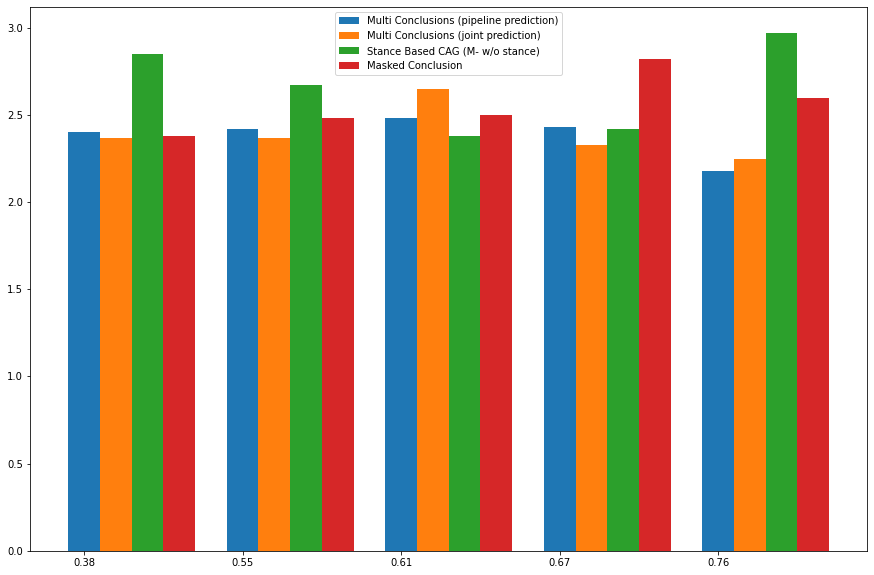

In [220]:
score_dist = {}
for clm_name, clm in pred_clms.items():
    score_dist[clm_name] = analyze_effetiveness(all_ann_df, clm, 'majority', dimension='max_sim_to_conclusion', num_buckets=5)

fig = plt.figure(figsize=(15,10))
width = 0.2 #/len(score_dist)
for i, item, in enumerate(score_dist.items()):
    app, app_scores = item[0], item[1]
    print(app, app_scores)
    xs, ys = zip(*app_scores)
    plt.bar([x + (i * width) for x in range(0, len(xs))], ys, width=width , label=app,)

plt.xticks(range(0, len(xs)), xs)
plt.legend()
plt.savefig('./figures/arg_len_to_manual_score_correlation.pdf')
plt.show()

Multi Conclusions (pipeline prediction) [(193.02, 2.37), (524.3, 2.4)]
Multi Conclusions (joint prediction) [(193.02, 2.36), (524.3, 2.43)]
Stance Based CAG (M- w/o stance) [(193.02, 2.73), (524.3, 2.59)]
Masked Conclusion [(193.02, 2.55), (524.3, 2.57)]


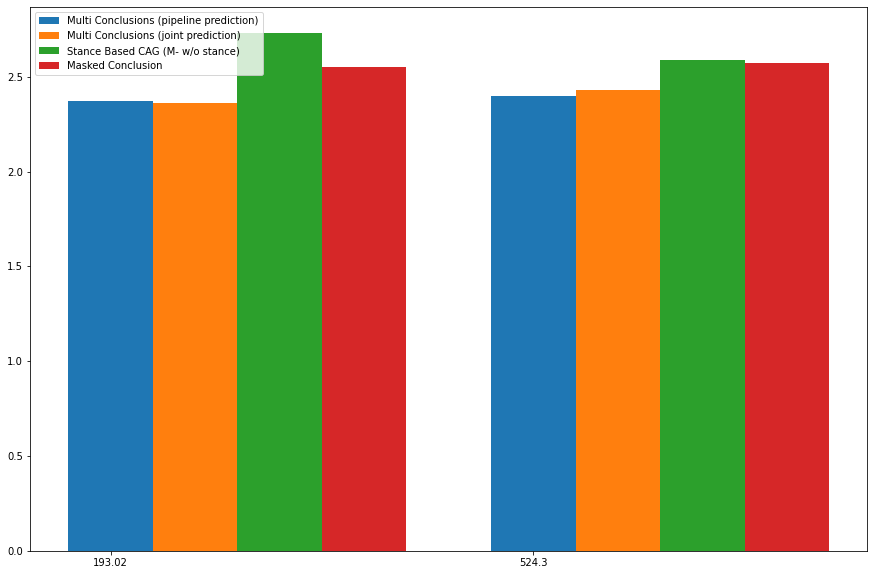

In [218]:
score_dist = {}
for clm_name, clm in pred_clms.items():
    score_dist[clm_name] = analyze_effetiveness(all_ann_df, clm, 'majority', dimension='argument_len', num_buckets=2)

fig = plt.figure(figsize=(15,10))
width = 0.2 #/len(score_dist)
for i, item, in enumerate(score_dist.items()):
    app, app_scores = item[0], item[1]
    print(app, app_scores)
    xs, ys = zip(*app_scores)
    plt.bar([x + (i * width) for x in range(0, len(xs))], ys, width=width , label=app,)

plt.xticks(range(0, len(xs)), xs)
plt.legend()
plt.savefig('./figures/arg_len_to_manual_score_correlation.pdf')
plt.show()

400
Multi Conclusions (pipeline prediction) dict_items([(1, 86), (2, 74), (3, 79), (4, 61)])
Multi Conclusions (joint prediction) dict_items([(1, 91), (2, 74), (3, 61), (4, 74)])
Stance Based CAG (M- w/o stance) dict_items([(1, 49), (2, 85), (3, 86), (4, 80)])
Masked Conclusion dict_items([(1, 75), (2, 67), (3, 74), (4, 84)])


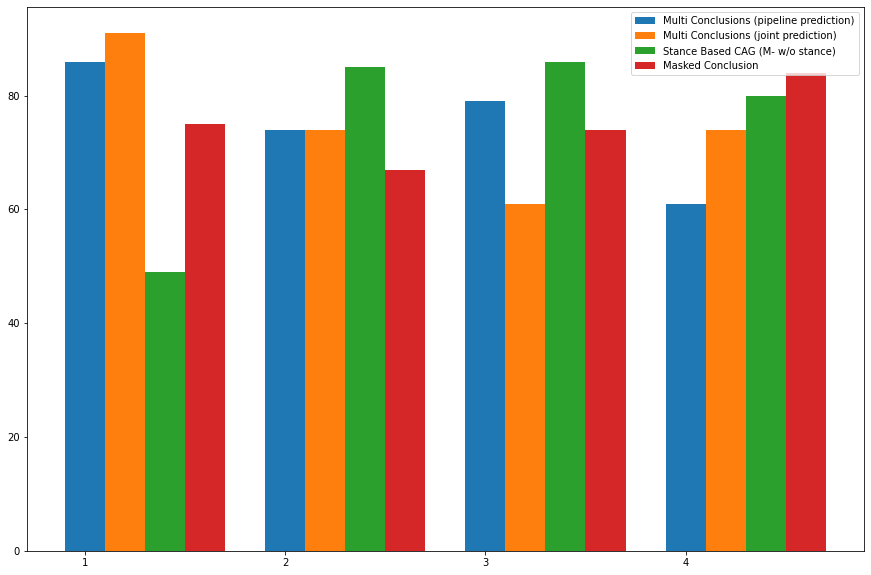

In [221]:
fig = plt.figure(figsize=(15,10))
width = 0.2
all_ann_df_with_maj = all_ann_df #all_ann_df[(all_ann_df.majority !=0)]
print(len(all_ann_df_with_maj))
for i, item, in enumerate(pred_clms.items()):
    app = item[0]
    #all_ranks = [(x , len(all_ann_df[(all_ann_df.app_name == item[1]) & (all_ann_df.avg_rank >= x) & (all_ann_df.avg_rank < x+1)])) for x in [1,2,3,4]]
    #all_ranks = list(all_ann_df_with_maj[all_ann_df_with_maj.app_name == item[1]]['majority'].value_counts().to_dict().items())
    #take all users' ranks into account
    all_ranks = all_ann_df[all_ann_df.app_name == item[1]]['Rank'].tolist() + all_ann_df[all_ann_df.app_name == item[1]]['Rank2'].tolist() + all_ann_df[all_ann_df.app_name == item[1]]['Rank3'].tolist()
    all_ranks = {x: all_ranks.count(x) for x in [1,2,3,4]}.items()
    
    app_scores = all_ranks # sorted(all_ranks, key=lambda x: -x[0])
    
    print(app, app_scores)
    xs, ys = zip(*app_scores)
    xs = [round(i) for i in xs]
    plt.bar([x + (i * width) for x in range(0, len(xs))], ys, width=width , label=app,)

plt.xticks(range(0, len(xs)), xs)
plt.legend()
plt.savefig('./figures/manual_ranking_scores.pdf')
plt.show()

#### Extracting some examples:

In [24]:
all_ann_df.columns

Index(['ID', 'Argument', 'Counter', 'Rank', 'Comment', 'Rank2', 'Comment2',
       'Rank3', 'Comment3', 'app_name', 'avg_rank', 'argument_len',
       'conclusion', 'max_sim_to_conclusion', 'majority'],
      dtype='object')

In [39]:
all_ann_df[(all_ann_df.argument_len < 400)][['ID', 'conclusion', 'Argument', 'Counter', "app_name", "majority"]].head(n=30)

,ID,conclusion,Argument,Counter,app_name,majority
0,t3_bu5s4p,abortion is murder and should be legal,"to start, i m a catholic who would never get an abortion due to an accidental pregnancy. however, there are countless cases where abortion is necessary. if the mother s health is deteriorating due to the pregnancy, abortion is necessary to keep her alive. at that point, the baby can t live on its own, but the mother can, as long as she is no longer pregnant. further, if the child will die upon being born or is brain dead, then an abortion should be performed because pregnancy is dangerous and there s no point in carrying out something that could hurt the mother when there s literally no payoff for having the child because it could never live. if the pregnancy is caused by rape or incest, the emotional toll on the mother could be extremely substantial and no one has the right to declare that a woman be put through that constant pain. i would get an abortion for any of the above reasons. however, other people want to get abortions for accidental pregnancies. they want to get abortions because they can t afford the pregnancy, let alone raising the child. they want to get abortions so they can keep up in a competing field. they want to get abortions so they won t have disabled kids. they want to get abortions simply because they don t want kids. while i personally disagree with doing this, i do not know what their lives are like and cannot accurately judge them. neither can any politician. plenty of murders are legally justified in cases of self defense and i think abortion should be included, because it s practically the definition of self defense. someone is going to seriously harm, kill, or ruin your life, so you have the right to choose to kill them. i m not saying that i like the idea of killing a fetus, but it s justifiable, and laws are supposed to be just.","abortion is a medical procedure, not a medical necessity. if a woman is pregnant, she has a right to choose to abort. if she doesn't want to have the baby, she should be able to do so. abortion is not a choice, it is a necessity.",pred_counter_arguments_no_stance,3
1,NaN,abortion is murder and should be legal,"to start, i m a catholic who would never get an abortion due to an accidental pregnancy. however, there are countless cases where abortion is necessary. if the mother s health is deteriorating due to the pregnancy, abortion is necessary to keep her alive. at that point, the baby can t live on its own, but the mother can, as long as she is no longer pregnant. further, if the child will die upon being born or is brain dead, then an abortion should be performed because pregnancy is dangerous and there s no point in carrying out something that could hurt the mother when there s literally no payoff for having the child because it could never live. if the pregnancy is caused by rape or incest, the emotional toll on the mother could be extremely substantial and no one has the right to declare that a woman be put through that constant pain. i would get an abortion for any of the above reasons. however, other people want to get abortions for accidental pregnancies. they want to get abortions because they can t afford the pregnancy, let alone raising the child. they want to get abortions so they can keep up in a competing field. they want to get abortions so they won t have disabled kids. they want to get abortions simply because they don t want kids. while i personally disagree with doing this, i do not know what their lives are like and cannot accurately judge them. neither can any politician. plenty of murders are legally justified in cases of self defense and i think abortion should be included, because it s practically the definition of self defense. someone is going to seriously harm, kill, or ruin your life, so you have the right to choose to kill them. i m not saying that i like the idea of killing a fetus, but it s justifiable, and laws are supposed to be just.","

#### A look at the comments:

In [72]:
from collections import Counter
import wordcloud
import nltk
from nltk import ngrams

In [55]:
from nltk.corpus import stopwords

In [69]:
good_comments = [str(x) for x in all_ann_df[all_ann_df.Rank == 1]['Comment'].tolist() + all_ann_df[all_ann_df.Rank2 == 1]['Comment2'].tolist() + all_ann_df[all_ann_df.Rank3 == 1]['Comment3'].tolist()]
bad_comments  = [str(x) for x in all_ann_df[all_ann_df.Rank == 4]['Comment'].tolist() + all_ann_df[all_ann_df.Rank2 == 4]['Comment2'].tolist() + all_ann_df[all_ann_df.Rank3 == 4]['Comment3'].tolist()]

our_good_comments = [str(x) for x in all_ann_df[(all_ann_df.Rank == 1) & (all_ann_df.app_name=='multi_counter_joint')]['Comment'].tolist() + all_ann_df[(all_ann_df.Rank2 == 1) & (all_ann_df.app_name=='multi_counter_joint')]['Comment2'].tolist() + all_ann_df[(all_ann_df.Rank3 == 1) & (all_ann_df.app_name=='multi_counter_joint')]['Comment3'].tolist()]
our_bad_comments  = [str(x) for x in all_ann_df[(all_ann_df.Rank == 4) & (all_ann_df.app_name=='multi_counter_joint')]['Comment'].tolist() + all_ann_df[(all_ann_df.Rank2 == 4) & (all_ann_df.app_name=='multi_counter_joint')]['Comment2'].tolist() + all_ann_df[(all_ann_df.Rank3 == 4) & (all_ann_df.app_name=='multi_counter_joint')]['Comment3'].tolist()]

baseline_good_comments = [str(x) for x in all_ann_df[(all_ann_df.Rank == 1) & (all_ann_df.app_name=='masked_conc_attacks')]['Comment'].tolist() + all_ann_df[(all_ann_df.Rank2 == 1) & (all_ann_df.app_name=='masked_conc_attacks')]['Comment2'].tolist() + all_ann_df[(all_ann_df.Rank3 == 1) & (all_ann_df.app_name=='masked_conc_attacks')]['Comment3'].tolist()]
baseline_bad_comments  = [str(x) for x in all_ann_df[(all_ann_df.Rank == 4) & (all_ann_df.app_name=='masked_conc_attacks')]['Comment'].tolist() + all_ann_df[(all_ann_df.Rank2 == 4) & (all_ann_df.app_name=='masked_conc_attacks')]['Comment2'].tolist() + all_ann_df[(all_ann_df.Rank3 == 4) & (all_ann_df.app_name=='masked_conc_attacks')]['Comment3'].tolist()]

##### Our good comments:
- ('argumentative language', 14) + ('is argumentative', 10)
- ('is coherent', 11) + ('coherent', 19)
- ('new perspective', 5) +  ('perspective', 8),
- ('it clearly states', 3)
- ('directly refutes', 3)
- opposes it on multiple points 2
- 
##### Our bad comments:
- ('only slightly addresses', 7),
- ('very vauge', 6),
- ('essentially supports', 3),
- ('unrelated', 3),
- ('incorrect', 3),
- ('not engage', 3),

##### Baseline bad comments:
- ("doesn't oppose", 6),
- ('lacks coherency', 5),
- ('repetitive', 4),

In [101]:
def show_ngrams(all_comments):
    comments_ngrams = [list(ngrams(c.lower().split(), 2)) + list(ngrams(c.lower().split(), 3)) + [[w] for w in c.lower().split()] for c in all_comments]
    comments_ngrams = [' '.join(x) for l in comments_ngrams for x in l]
    c = Counter(comments_ngrams)
    return c.most_common()

In [102]:
show_ngrams(our_good_comments)

[('the', 178),
 ('is', 77),
 ('argument', 55),
 ('and', 50),
 ('this', 45),
 ('that', 39),
 ('of', 38),
 ('it', 37),
 ('to', 36),
 ('a', 36),
 ('counter', 29),
 ('this is', 29),
 ('is the', 28),
 ('language', 28),
 ('argumentative', 26),
 ('best', 25),
 ('this is the', 25),
 ('addresses', 25),
 ('the argument', 22),
 ('the best', 21),
 ('of the', 20),
 ('the original', 20),
 ('original', 20),
 ('counter argument', 19),
 ('because', 19),
 ('coherent', 19),
 ('but', 18),
 ('opposes', 18),
 ('because it', 16),
 ('best counter', 16),
 ('the best counter', 16),
 ('argument because', 15),
 ('is the best', 15),
 ('not', 15),
 ('only', 15),
 ('argument,', 15),
 ('opposes the', 15),
 ('counter argument because', 14),
 ('as', 14),
 ('best counter argument', 14),
 ('argument.', 14),
 ('on', 14),
 ('argumentative language', 14),
 ('addresses the', 14),
 ('the main', 13),
 ('argument because it', 13),
 ('main', 13),
 ('in', 13),
 ('the only', 13),
 ('the language', 13),
 ('to the', 12),
 ('is the o

In [103]:
show_ngrams(our_bad_comments)

[('the', 105),
 ('is', 56),
 ('argument', 42),
 ('it', 39),
 ('not', 34),
 ('and', 33),
 ('this', 30),
 ('does', 25),
 ('does not', 23),
 ('argument,', 20),
 ('of', 20),
 ('counter', 20),
 ('the main', 19),
 ('main', 19),
 ('but', 19),
 ('language', 18),
 ('a', 17),
 ('the original', 17),
 ('original', 17),
 ('argumentative', 17),
 ('of the', 15),
 ('argument.', 15),
 ('coherent', 15),
 ('the worst', 14),
 ('worst', 14),
 ('in', 14),
 ('because', 13),
 ('counter argument', 13),
 ('to', 13),
 ('it is', 12),
 ('that', 12),
 ('this is', 12),
 ('the argument', 12),
 ('only', 11),
 ('very', 11),
 ('any', 11),
 ('because it', 11),
 ('worst counter', 11),
 ('the worst counter', 11),
 ('argumentative language', 11),
 ('as', 10),
 ('argument because', 10),
 ('worst counter argument', 10),
 ('counter argument because', 10),
 ('original argument', 10),
 ('the original argument', 10),
 ('addresses the', 10),
 ('addresses', 10),
 ('also', 9),
 ('is the', 9),
 ('with', 9),
 ('it does', 9),
 ('suppor

In [104]:
show_ngrams(baseline_bad_comments)

[('the', 140),
 ('argument', 63),
 ('is', 50),
 ('and', 35),
 ('this', 34),
 ('it', 34),
 ('the original', 30),
 ('original', 30),
 ('of', 28),
 ('not', 22),
 ('counter', 21),
 ('language', 21),
 ('argumentative', 21),
 ('of the', 20),
 ('the argument', 20),
 ('the main', 18),
 ('main', 18),
 ('argument.', 18),
 ('counter argument', 17),
 ('because', 16),
 ('original argument', 16),
 ('the original argument', 16),
 ('but', 16),
 ('this is', 15),
 ('the language', 15),
 ('argument because', 14),
 ('counter argument because', 14),
 ('with', 14),
 ('because it', 13),
 ('worst', 13),
 ('a', 13),
 ('does not', 13),
 ('does', 13),
 ('the worst', 12),
 ('worst counter', 12),
 ('the worst counter', 12),
 ('worst counter argument', 12),
 ('argument because it', 12),
 ('as', 11),
 ('on', 11),
 ('argument at', 11),
 ('at', 11),
 ('argument,', 11),
 ('from the', 11),
 ('from', 11),
 ('agrees', 11),
 ('original argument.', 11),
 ('the original argument.', 11),
 ('addresses the', 11),
 ('addresses',

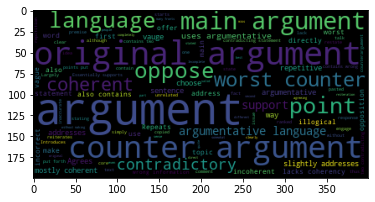

In [65]:
word_cloud = wordcloud.WordCloud(stopwords=stopwords.words('english')).generate(' '.join(bad_comments))
    
plt.imshow(word_cloud)
plt.show()

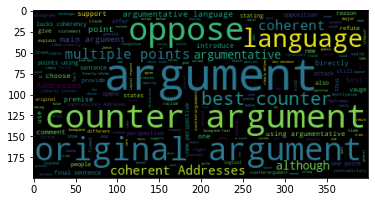

In [64]:
word_cloud = wordcloud.WordCloud(stopwords=stopwords.words('english')).generate(' '.join(good_comments))
    
plt.imshow(word_cloud)
plt.show()

--------

### Conclusion evaluation results:

In [ ]:
fs_results_df = pd.read_excel('../data/manual_evaluation/results/conclusion_eval_fs.xlsx')
ji_results_df = pd.read_excel('../data/manual_evaluation/results/conclusion_eval_ji.xlsx')

conclusion_eval_df = pd.read_csv('../data/manual_evaluation/eval_conclusion_sample.csv')

all_ann_df = ji_results_df
all_ann_df['Valid2']    = fs_results_df['Valid'].tolist()
all_ann_df['app_name'] = conclusion_eval_df['Approach name'].tolist()
all_ann_df['avg_score'] = all_ann_df.apply(lambda row: (row['Valid'] + row['Valid2'])/2, axis=1)

In [ ]:
all_ann_df.head()

In [ ]:
all_ann_df[['app_name', 'avg_score']].groupby('app_name').agg({'avg_score': lambda x: np.mean(x)})

In [ ]:
cohen_kappa_score(all_ann_df.Valid, all_ann_df.Valid2, weights='linear')